# Meshuggah Dataset Creation

In [5]:
import glob
from IPython.display import Audio
import librosa
from librosa import display
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from sklearn.cluster import KMeans
from tqdm import tqdm

SR = 22050
HOP_LEN = 4096
FRAME_LEN = HOP_LEN * 2  # 50% overlap
CQT_BINS = 80
N_CLUSTERS = 20000
AUDIO_FILES = glob.glob("/Users/uri/Dropbox/Music/Meshuggah/*/*.mp3")
CQT_FRAMES_NPY = "../data/cqt_frames.npy"
AUDIO_FRAMES_NPY = "../data/audio_frames.npy"
METADATA_TSV = "../data/metadata.tsv"

%matplotlib inline

## Feature Extraction

Let's get a bunch of Meshuggah albums and extract the Constant-Q Transform of each of the songs.

Store each CQT and audio frame separately.

In [2]:
def compute_features(audio_file):
    """Computes the log-scaled Constant-Q Transform and corresponding audio slices."""
    # Read audio file
    y, sr = librosa.load(audio_file, sr=SR)
    
    # Get CQT
    cqt = librosa.cqt(y, sr=SR, hop_length=HOP_LEN, n_bins=CQT_BINS, pad_mode="edge")
    
    # Slice audio in overlapping frames
    y_sliced = librosa.util.frame(np.concatenate((y, np.zeros(FRAME_LEN))), 
                                  frame_length=FRAME_LEN, hop_length=HOP_LEN)
    
    # Make sure we have the same lengths
    assert y_sliced.shape[1] == cqt.shape[1]
    
    # Return audio slices and logscaled CQT
    return y_sliced.T, librosa.amplitude_to_db(cqt, ref=np.max).T

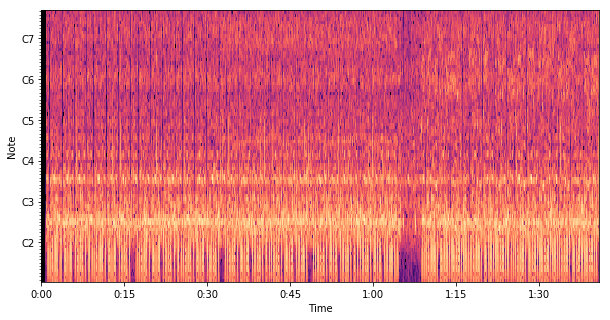

In [3]:
# Visualize CQT features
plt.figure(figsize=(10, 5))
y_sliced, cqt = compute_features(AUDIO_FILES[0])
display.specshow(cqt.T, sr=SR, hop_length=HOP_LEN, x_axis='time', y_axis='cqt_note')

In [4]:
metadata = []  # We will save: (index, start frame, end frame, title)
all_audio_frames = []
all_cqt_frames = []
last_frame = 0
for i, audio_file in tqdm(enumerate(AUDIO_FILES), total=len(AUDIO_FILES)):
    y_sliced, cqt = compute_features(audio_file)
    
    # Store metadata
    metadata.append({
            "index": i,
            "start": last_frame,
            "end": last_frame + cqt.shape[0] - 1,
            "title": os.path.basename(audio_file)})

    # Store data
    last_frame += cqt.shape[0]
    all_cqt_frames.append(cqt)
    all_audio_frames.append(y_sliced)

# Put together
all_cqt_frames = np.concatenate(all_cqt_frames, axis=0)
all_audio_frames = np.concatenate(all_audio_frames, axis=0)

# Save to disk
np.save(AUDIO_FRAMES_NPY, all_audio_frames)
np.save(CQT_FRAMES_NPY, all_cqt_frames)
df = pd.DataFrame(metadata)
df = df[["index", "start", "end", "title"]]
df.to_csv(METADATA_TSV, sep='\t', index=False)

100%|██████████| 60/60 [14:56<00:00, 18.80s/it]


## Cluster the Frames

Let's get a symbolic representation for each of the frames, which will become to input to the RNN

In [2]:
all_cqt_frames = np.load(CQT_FRAMES_NPY)
all_audio_frames = np.load(AUDIO_FRAMES_NPY)

In [ ]:
kmeans = KMeans(n_clusters=N_CLUSTERS, max_iter=600)
# Run k-means (this might take a while)
sym_frames = kmeans.fit_transform(all_cqt_frames)

## Produce Audio

In [15]:
frame_idxs = np.arange(400, 642)
print(len(frame_idxs))
audio = np.zeros(len(frame_idxs) * HOP_LEN + FRAME_LEN)
for i, frame_idx in enumerate(frame_idxs):
    audio_frame = np.hanning(FRAME_LEN) * all_audio_frames[frame_idx]
    audio[i * HOP_LEN: i * HOP_LEN + FRAME_LEN] += audio_frame

242
